# Статистические тесты в контексте EDA #

Описание задания и решение приведены в README-файле по ссыдке:    
[https://github.com/stalkspectrum/sf-ds-course-all/blob/master/03-34-EDA-4/EDA4_Task/README.md](https://github.com/stalkspectrum/sf-ds-course-all/blob/master/03-34-EDA-4/EDA4_Task/README.md)

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

## 1. Загрузка и обработка данных ##

In [2]:
main_df = pd.read_csv('salaries.csv')
copy_df = main_df.copy()    # Резервная копия для дополнительных исследований
display(main_df.head())

,Unnamed: 0,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


##### Проверка наличия пустых ячеек по признакам: #####

In [3]:
main_df.isnull().sum()

Unnamed: 0            0
work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

#### Проверка наличия дубликатов: ####

In [4]:
print(f'Найдено дубликатов - {main_df[main_df.duplicated].shape[0]}')

Найдено дубликатов - 0


Пустот и дубликатов не обнаружено, теперь можно сразу избавиться от
неинформативных признаков.

Первая колонка **`Unnamed: 0`**&nbsp;&mdash; просто порядковый номер, явно
неинформативный.

Стоит ли удалять зарплату в национальных валютах **`salary`**?

In [5]:
main_df[['salary', 'salary_in_usd']].corr()

,salary,salary_in_usd
salary,1.000000,-0.083906
salary_in_usd,-0.083906,1.000000


Если подходить формально, признаки **`salary`** и **`salary_in_usd`** показывают
очень слабую корреляцию. Однако если построить график соотношения зарплаты в
национальных валютах (`salary`) к зарплате в долларах США (`salary_in_usd`) хотя
бы для самых популярных валют помимо доллара США:

In [6]:
main_df.salary_currency.value_counts().nlargest(5)

salary_currency
USD    398
EUR     95
GBP     44
INR     27
CAD     18
Name: count, dtype: int64

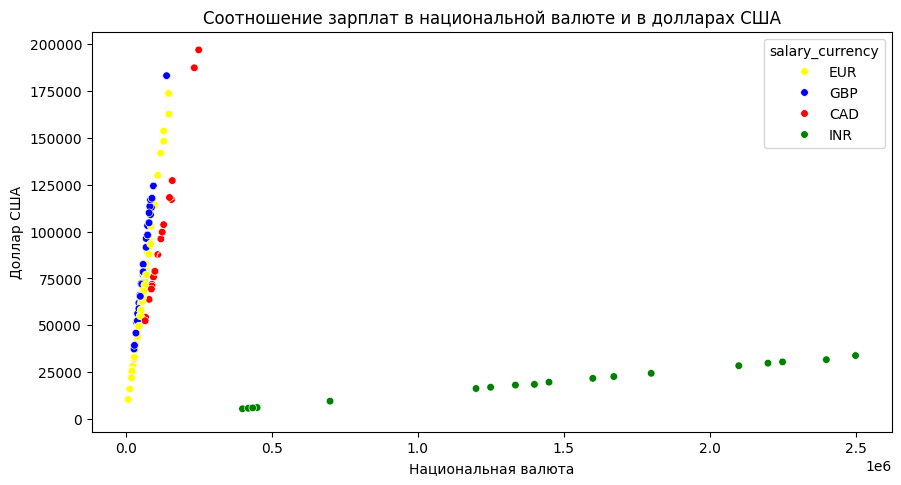

In [7]:
# Выбираем евро, британский фунт, канадский доллар, индийскую рупию.

fig = plt.figure(figsize=(8, 4))
axes = fig.add_axes([0, 0, 1, 1])
tmp_df = main_df[(main_df['salary'] <= 2500000)]
sns.scatterplot(
    data=tmp_df[tmp_df['salary_currency'] != 'USD'],
    x='salary',
    y='salary_in_usd',
    hue='salary_currency',
    hue_order=['EUR', 'GBP', 'CAD', 'INR'],
    palette={'EUR': 'yellow', 'GBP': 'blue', 'CAD': 'red', 'INR': 'green'},
    s=30,
    ax=axes
)
axes.set_title('Соотношение зарплат в национальной валюте и в долларах США')
axes.set_xlabel('Национальная валюта')
axes.set_ylabel('Доллар США');

то видно, что по каждой валюте зависимость получается практически прямой
(плюс-минус годовые колебания курсов), что означает очень сильную корреляцию.
Это можно показать численно по каждой валюте отдельно:

In [8]:
for currency_ in ['EUR', 'GBP', 'CAD', 'INR']:
    corr_ = round(main_df[main_df.salary_currency == currency_]\
        [['salary', 'salary_in_usd']].corr().iloc[0][1], 4)
    print(f'Коэффициент корреляции по {currency_}: {corr_}')

Коэффициент корреляции по EUR: 0.9973
Коэффициент корреляции по GBP: 0.9976
Коэффициент корреляции по CAD: 0.999
Коэффициент корреляции по INR: 0.9998


Так что можно вполне обоснованно вместе с **`Unnamed: 0`** отбросить признаки
**`salary`** и сопутствующий ему **`salary_currency`**:

In [9]:
main_df.drop(['Unnamed: 0', 'salary', 'salary_currency'], axis='columns', inplace=True)

##### Проверка корректности типов данных #####

In [10]:
display(main_df.info())
print(f'В признаке "work_year" уникальных значений - {main_df.work_year.nunique()}')
print(list(main_df.work_year.unique()))
print(f'В признаке "remote_ratio" уникальных значений - {main_df.remote_ratio.nunique()}')
print(list(main_df.remote_ratio.unique()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607 entries, 0 to 606
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary_in_usd       607 non-null    int64 
 5   employee_residence  607 non-null    object
 6   remote_ratio        607 non-null    int64 
 7   company_location    607 non-null    object
 8   company_size        607 non-null    object
dtypes: int64(3), object(6)
memory usage: 42.8+ KB


None

В признаке "work_year" уникальных значений - 3
[2020, 2021, 2022]
В признаке "remote_ratio" уникальных значений - 3
[0, 50, 100]


В числовых признаках **`work_year`** и **`remote_ratio`** только по три уникальных значения, поэтому их можно смело преобразовать в категориальные. Таким образом останется только один числовой непрерывный признак **`salary_in_usd`**.

In [11]:
def set_remote_category(per_cent: int) -> str:
    ''' Преобразует числовой процент удалённой работы в строковую
        категорию no-remote/part-remote/full-remote
    Arguments:
        per_cent [int] -- Доля удалённой работы в процентах
    Returns:
        [str] -- Категория no-remote/part-remote/full-remote
    '''
    if per_cent < 20:
        return 'no-remote'
    elif per_cent > 80:
        return 'full-remote'
    else:
        return 'part-remote'

# Преобразование work_year из числа в строку
main_df.work_year = main_df.work_year.apply(lambda x: str(x))
# Преобразование remote_ratio из числа в строковую категорию
main_df.remote_ratio = main_df.remote_ratio.apply(set_remote_category)

##### Проверка числа категорий по признакам #####

In [12]:
main_df.describe(include=['object'])

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,607,607,607,607,607,607,607,607
unique,3,4,4,50,57,3,50,3
top,2022,SE,FT,Data Scientist,US,full-remote,US,M
freq,318,280,588,143,332,381,355,326


Необходимо сократить число категорий в признаках **`job_title`**, **`employee_residence`** и **`company_location`**.

Посмотрим признак **`job_title`**:

In [13]:
main_df.job_title.value_counts().nlargest(10)

job_title
Data Scientist                143
Data Engineer                 132
Data Analyst                   97
Machine Learning Engineer      41
Research Scientist             16
Data Science Manager           12
Data Architect                 11
Big Data Engineer               8
Machine Learning Scientist      8
Principal Data Scientist        7
Name: count, dtype: int64

В признаке **`job_title`** для дальнейшего анализа нас будут интересовать только роли **`Data Scientist`** и **`Data Engineer`**. К тому же они составляют около половины датасета. Остальные роли можно объединить в одну **`Other`**.

In [14]:
main_df.job_title = main_df.job_title.apply(lambda x: x if x in ['Data Scientist',
                                                                 'Data Engineer']
                                                      else 'Other')

Теперь посмотрим признак **`employee_residence`**:

In [15]:
main_df.employee_residence.value_counts().nlargest(10)

employee_residence
US    332
GB     44
IN     30
CA     29
DE     25
FR     18
ES     15
GR     13
JP      7
PT      6
Name: count, dtype: int64

В признаке **`employee_residence`** больше половины сотрудников работают в США. Поэтому этот признак можно свести к двум категориям: **`US`** и **`Other`**.

In [16]:
main_df.employee_residence = main_df.employee_residence.apply(lambda x: x if x == 'US'
                                                                        else 'Other')

Аналогично смотрим признак **`company_location`**:

In [17]:
main_df.company_location.value_counts().nlargest(10)

company_location
US    355
GB     47
CA     30
DE     28
IN     24
FR     15
ES     14
GR     11
JP      6
NL      4
Name: count, dtype: int64

И в признаке **`company_location`** также оставляем только две категории: **`US`** и **`Other`**:

In [18]:
main_df.company_location = main_df.company_location.apply(lambda x: x if x == 'US'
                                                                    else 'Other')

##### Основная статистика по числовому признаку #####

In [19]:
main_df.salary_in_usd.describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

##### Итоговая статистика по категориальным признакам #####

In [20]:
main_df.describe(include=['object'])

,work_year,experience_level,employment_type,job_title,employee_residence,remote_ratio,company_location,company_size
count,607,607,607,607,607,607,607,607
unique,3,4,4,3,2,3,2,3
top,2022,SE,FT,Other,US,full-remote,US,M
freq,318,280,588,332,332,381,355,326


## 2. Разведывательный анализ данных ##

### 2.1. Визуальный анализ данных ###

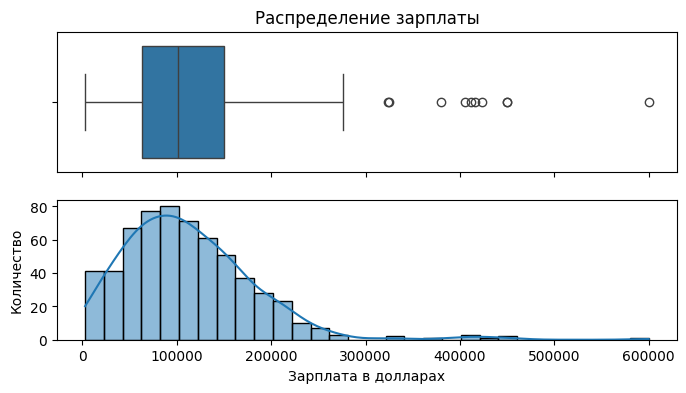

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(8, 4), sharex=True)
sns.boxplot(
    data=main_df.salary_in_usd,
    orient='h',
    ax=ax1
)
sns.histplot(
    data=main_df['salary_in_usd'],
    bins=30,
    kde=True,
    legend=False,
    ax=ax2
)
ax1.set_title('Распределение зарплаты')
ax1.set_xlabel('')
ax2.set_xlabel('Зарплата в долларах')
ax2.set_ylabel('Количество');

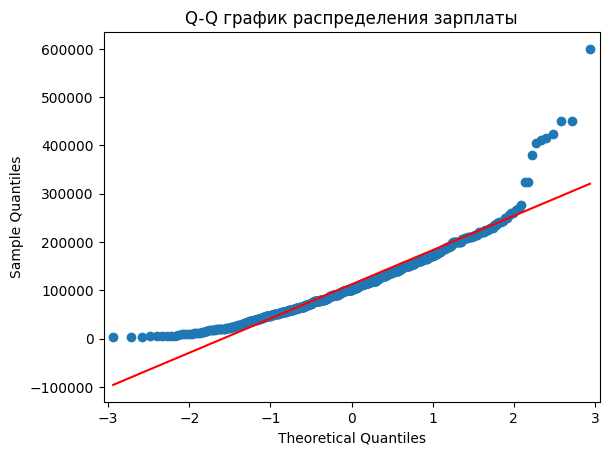

In [22]:
sm.qqplot(main_df['salary_in_usd'], line='s')
plt.title('Q-Q график распределения зарплаты')
plt.show()

По графикам можно судить, что распределение зарплат заметно отличается от
нормального и больше похоже на логарифмически нормальное, или даже на
распределение Максвелла.

Для уверенности можно провести несколько численных статистических тестов по
разным выборкам.

### 2.2. Статистический анализ данных ###

##### Численные тесты Шапиро-Уилка по годовым и должностным выборкам #####

In [23]:
alpha = 0.05

''' Тесты распределений по годовым иыборкам '''
for year_ in list(main_df.work_year.unique()):
    salaries_ = main_df[main_df.work_year == year_].salary_in_usd
    bulk_, p = stats.shapiro(salaries_)
    print(f'{year_} год: p-value = {p}')
    if p <= alpha:
        print('Распределение ненормальное')
    else:
        print('Распределение нормальное')

''' Тесты распределений по должностям '''
for job_ in list(main_df.job_title.unique()):
    salaries_ = main_df[main_df.job_title == job_].salary_in_usd
    bulk_, p = stats.shapiro(salaries_)
    print(f'Должность {job_}: p-value = {p}')
    if p <= alpha:
        print('Распределение ненормальное')
    else:
        print('Распределение нормальное')

2020 год: p-value = 3.4662623882297794e-09
Распределение ненормальное
2021 год: p-value = 7.0667619976247376e-15
Распределение ненормальное
2022 год: p-value = 2.2347774120135e-07
Распределение ненормальное
Должность Data Scientist: p-value = 3.764461143873632e-05
Распределение ненормальное
Должность Other: p-value = 1.7828324327517892e-16
Распределение ненормальное
Должность Data Engineer: p-value = 0.010073374025523663
Распределение ненормальное


Распределение зарплат в различных выборках отличается от нормального,
следовательно в дальнейшем для анализа зарплаты следует использовать
непараметрические тесты.

Ещё интересно выяснить зависимость групп по годам и должностям:

In [24]:
main_df.groupby(['job_title', 'work_year'])[['job_title']].count()


job_title
job_title      work_year           
Data Engineer  2020              11
               2021              32
               2022              89
Data Scientist 2020              21
               2021              45
               2022              77
Other          2020              40
               2021             140
               2022             152

Видно, что по годам число опрошенных профессионалов меняется. То есть надо
учитывать, что это не группы одних и тех же людей в разные годы, а совершенно
независимые группы.


----

***Примечание:***

Другой графический и численный анализ данных по необходимости будет проведён в
разделе 3 при ответах на бизнес-вопросы.

----


## 3. Бизнес-вопросы ##

### 3.1. Наблюдается ли ежегодный рост зарплат у специалистов **`Data Scientist`**? ###

Для начала построим графики средних и медианных зарплат **`Data Scientist`** по
годам.

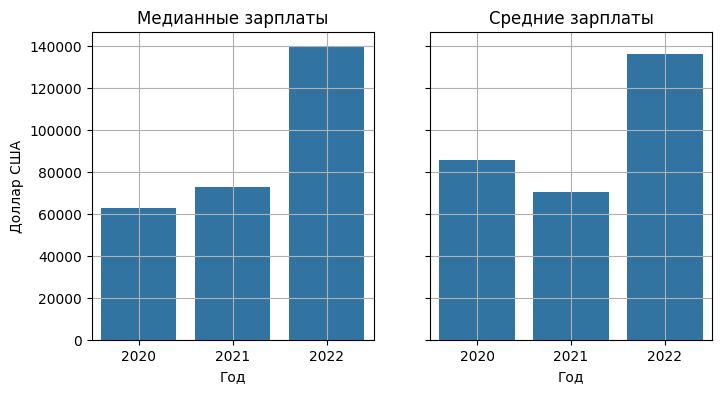

In [25]:
ds_salary_median_df = main_df[main_df.job_title == 'Data Scientist']\
                             .groupby(['work_year'])[['salary_in_usd']]\
                             .median()
ds_salary_mean_df = main_df[main_df.job_title == 'Data Scientist']\
                           .groupby(['work_year'])[['salary_in_usd']]\
                           .mean()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
sns.barplot(
    data=ds_salary_median_df,
    x='work_year',
    y='salary_in_usd',
    ax=axes[0]
)
sns.barplot(
    data=ds_salary_mean_df,
    x='work_year',
    y='salary_in_usd',
    ax=axes[1]
)
axes[0].set_title('Медианные зарплаты')
axes[0].set_xlabel('Год')
axes[0].set_ylabel('Доллар США')
axes[0].grid()
axes[1].set_title('Средние зарплаты')
axes[1].set_xlabel('Год')
axes[1].grid()

Если в 2022 году зарплаты уверенно выросли, то для 2021 года не совсем очевидно.
Поскольку выяснилось, что у нас нет нормального распределения и группы
независимы, то для выяснения роста зарплаты в 2021 году можно применить
**U-критерий Манна-Уитни**.

Зададим уровень значимости $\alpha=0,10$ и сформулируем гипотезы:

$H_0: \mu_1 \ge \mu_2$ &mdash; зарплаты не изменились или уменьшились.

$H_1: \mu_1 < \mu_2$ &mdash; зарплаты увеличились (левосторонняя альтернативная
гипотеза).

Проверим гипотезы как для 2021 года, так и для 2022:

In [26]:
alpha = 0.1
# Выборки зарплат Data Scientist за 2020, 2021, 2022 годы
ds_salary_2020 = main_df[main_df.job_title == 'Data Scientist']\
                        .loc[main_df.work_year == '2020']\
                        .salary_in_usd
ds_salary_2021 = main_df[main_df.job_title == 'Data Scientist']\
                        .loc[main_df.work_year == '2021']\
                        .salary_in_usd
ds_salary_2022 = main_df[main_df.job_title == 'Data Scientist']\
                        .loc[main_df.work_year == '2022']\
                        .salary_in_usd

# Тест для 2021 года
bulk_, p = stats.mannwhitneyu(ds_salary_2020, ds_salary_2021, alternative='less')
print(f'2021 год:\np-value = {p:.10f}')
if p <= alpha:
    print('Отвергаем нулевую гипотезу. Зарплаты увеличились\n')
else:
    print('Принимаем нулевую гипотезу. Зарплаты не изменились или уменьшились\n')

# Тест для 2022 года
bulk_, p = stats.mannwhitneyu(ds_salary_2021, ds_salary_2022, alternative='less')
print(f'2022 год:\np-value = {p:.10f}')
if p <= alpha:
    print('Отвергаем нулевую гипотезу. Зарплаты увеличились\n')
else:
    print('Принимаем нулевую гипотезу. Зарплаты не изменились или уменьшились\n')

2021 год:
p-value = 0.6850483302
Принимаем нулевую гипотезу. Зарплаты не изменились или уменьшились

2022 год:
p-value = 0.0000000025
Отвергаем нулевую гипотезу. Зарплаты увеличились



Таким образом, ответ на бизнес-вопрос&nbsp;&mdash; отрицательный. Рост уверенно наблюдается только в 2022 году.

### 3.2. Как соотносятся зарплаты **`Data Scientist`** и **`Data Engineer`** в 2022 году? ###

Для начала построим диаграммы средних и медианных зарплат **`Data Scientist`** и
**`Data Engineer`** в 2022 году:

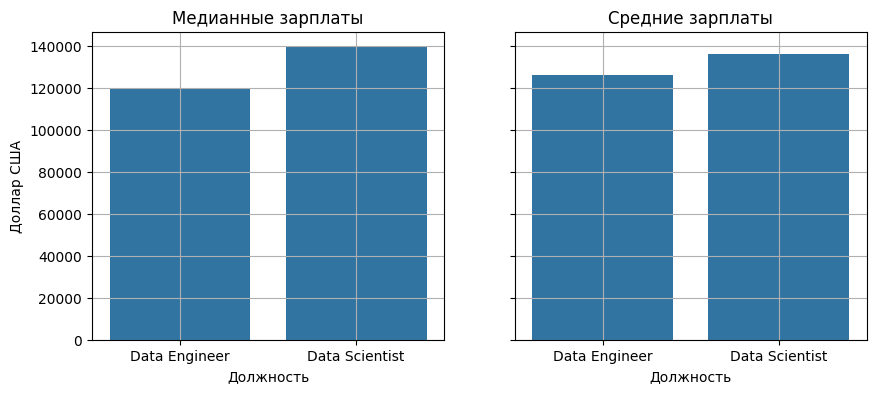

In [49]:
# Медианные зарплаты по должностям (без Other) за 2022 год
salary_median_df = main_df[main_df.job_title != 'Other']\
                          .loc[main_df.work_year == '2022']\
                          .groupby(['job_title', 'work_year'])\
                          [['salary_in_usd']].median()
# Средние зарплаты по должностям (без Other) за 2022 год
salary_mean_df = main_df[main_df.job_title != 'Other']\
                        .loc[main_df.work_year == '2022']\
                        .groupby(['job_title', 'work_year'])\
                        [['salary_in_usd']].mean()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4), sharey=True)
sns.barplot(
    data=salary_median_df,
    x='job_title',
    y='salary_in_usd',
    ax=axes[0]
)
sns.barplot(
    data=salary_mean_df,
    x='job_title',
    y="salary_in_usd",
    ax=axes[1]
)
axes[0].set_title('Медианные зарплаты')
axes[0].set_xlabel('Должность')
axes[0].set_ylabel('Доллар США')
axes[0].grid()
axes[1].set_title('Средние зарплаты')
axes[1].set_xlabel('Должность')
axes[1].grid()

На первый взгляд кажется, что в 2022 году у **`Data Scientist`** зарплаты выше,
чем у **`Data Engineer`**, но разница невелика. Опять применяем **U-критерий
Манна-Уитни** для двух независимых групп при ненормальном распределении.

Зададим уровень значимости $\alpha=0,10$ и сформулируем гипотезы:

$H_0: \mu_1 = \mu_2$ &mdash; зарплаты **`Data Engineer`** равны зарплатам
**`Data Scientist`**.

$H_1: \mu_1 \ne \mu_2$ &mdash; зарплаты **`Data Engineer`** не равны зарплатам
**`Data Scientist`** (двухсторонняя альтернативная гипотеза).

In [28]:
alpha = 0.1
# Выборка зарплат Data Engineer за 2022 год
de_salary_2022 = main_df[main_df.job_title == 'Data Engineer']\
                        .loc[main_df.work_year == '2022']\
                        .salary_in_usd
# Выборка зарплат Data Scientist за 2022 год
ds_salary_2022 = main_df[main_df.job_title == 'Data Scientist']\
                        .loc[main_df.work_year == '2022']\
                        .salary_in_usd

# Тест гипотезы
# bulk_, p = stats.mannwhitneyu(de_salary_2022, ds_salary_2022, alternative='less')
bulk_, p = stats.mannwhitneyu(de_salary_2022, ds_salary_2022)
print(f'p-value = {p:.3f}')
if p <= alpha:
    print('Отвергаем нулевую гипотезу. Зарплаты Data Scientist не равны зарплатам Data Engineer')
else:
    print('Принимаем нулевую гипотезу. Зарплаты Data Scientist равны зарплатам Data Engineer')

p-value = 0.155
Принимаем нулевую гипотезу. Зарплаты Data Scientist равны зарплатам Data Engineer


Таким образом, ответ на бизнес-вопрос&nbsp;&mdash; зарплаты **`Data Scientist`** и **`Data Engineer`** в 2022 году примерно одинаковы.

### 3.3. Как соотносятся зарплаты специалистов **`Data Scientist`** в компаниях различных размеров? ###

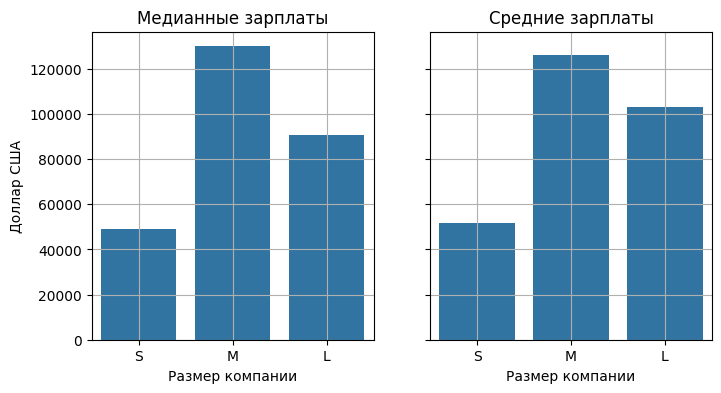

In [29]:
ds_salary_median_df = main_df[main_df.job_title == 'Data Scientist']\
                             .groupby(['company_size'])[['salary_in_usd']]\
                             .median()
ds_salary_mean_df = main_df[main_df.job_title == 'Data Scientist']\
                           .groupby(['company_size'])[['salary_in_usd']]\
                           .mean()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)
sns.barplot(
    data=ds_salary_median_df,
    x='company_size',
    y='salary_in_usd',
    order=['S', 'M', 'L'],
    ax=axes[0]
)
sns.barplot(
    data=ds_salary_mean_df,
    x='company_size',
    y='salary_in_usd',
    order=['S', 'M', 'L'],
    ax=axes[1]
)
axes[0].set_title('Медианные зарплаты')
axes[0].set_xlabel('Размер компании')
axes[0].set_ylabel('Доллар США')
axes[0].grid()
axes[1].set_title('Средние зарплаты')
axes[1].set_xlabel('Размер компании')
axes[1].grid()

На первый взгляд кажется, что в целом в **large**-компаниях зарплаты
**существенно** выше, чем в **small**-компаниях, но **не так сильно** меньше,
чем в **middle**-компаниях. Для численной проверки опять используем
**U-критерий Манна-Уитни** дважды попарно (для соотношения **small-large** и для
соотношения **large-middle**).

Зададим уровень значимости $\alpha=0,10$ и сформулируем гипотезы для соотношения
**small-large**:

$H_0: \mu_1 \ge \mu_2$ &mdash; зарплаты в **small**-компаниях равны или больше
зарплат в **large**-компаниях.

$H_1: \mu_1 < \mu_2$ &mdash; зарплаты в **small**-компаниях меньше зарплат в
**large**-компаниях. (левосторонняя альтернативная гипотеза).

Сформулируем гипотезы для соотношения **large-middle**:

$H_0: \mu_1 = \mu_2$ &mdash; зарплаты в **large**-компаниях равны зарплатам в
**middle**-компаниях.

$H_1: \mu_1 \ne \mu_2$ &mdash; зарплаты в **large**-компаниях не равны зарплатам
в **middle**-компаниях. (двухсторонняя альтернативная гипотеза).

In [30]:
alpha = 0.1
# Выборки зарплат для small/middle/large-компаний
salary_small_co = main_df[main_df.company_size == 'S'].salary_in_usd
salary_middle_co = main_df[main_df.company_size == 'M'].salary_in_usd
salary_large_co = main_df[main_df.company_size == 'L'].salary_in_usd

# Тест для соотношения small-large
bulk_, p = stats.mannwhitneyu(salary_small_co, salary_large_co, alternative='less')
print(f'p-value = {p:.10f}')
if p <= alpha:
    print('Отвергаем нулевую гипотезу. Зарплаты в small-компаниях меньше, чем в large-компаниях\n')
else:
    print('Принимаем нулевую гипотезу. Зарплаты в small-компаниях равны или больше, чем в large-компаниях\n')

# Тест для соотношения large-middle
bulk_, p = stats.mannwhitneyu(salary_large_co, salary_middle_co, alternative='two-sided')
print(f'p-value = {p:.10f}')
if p <= alpha:
    print('Отвергаем нулевую гипотезу. Зарплаты в large-компаниях не равны зарплатам в middle-компаниях\n')
else:
    print('Принимаем нулевую гипотезу. Зарплаты в large-компаниях равны зарплатам в middle-компаниях\n')

p-value = 0.0000036899
Отвергаем нулевую гипотезу. Зарплаты в small-компаниях меньше, чем в large-компаниях

p-value = 0.2155729178
Принимаем нулевую гипотезу. Зарплаты в large-компаниях равны зарплатам в middle-компаниях



Таким образом, ответ на бизнес-вопрос&nbsp;&mdash; зарплаты в **large**- и
**middle**-компаниях примерно одинаковы, но существенно больше, чем в
**small**-компаниях.

### 3.4. Есть ли связь между наличием должностей **`Data Scientist`** и **`Data Engineer`** и размером компании? ###

In [31]:
main_df.company_size.value_counts()

company_size
M    326
L    198
S     83
Name: count, dtype: int64

job_title,Data Engineer,Data Scientist,Other,total,ds_percent,de_percent
company_size,,,,,,
L,37,45,116,198,23.0,19.0
M,89,77,160,326,24.0,27.0
S,6,21,56,83,25.0,7.0


company_size,L,M,S
job_title,,,
Data Engineer,37,89,6
Data Scientist,45,77,21
Other,116,160,56


198

company_size,L,M,S
job_title,,,
Data Engineer,19.0,27.0,7.0
Data Scientist,23.0,24.0,25.0
Other,59.0,49.0,67.0


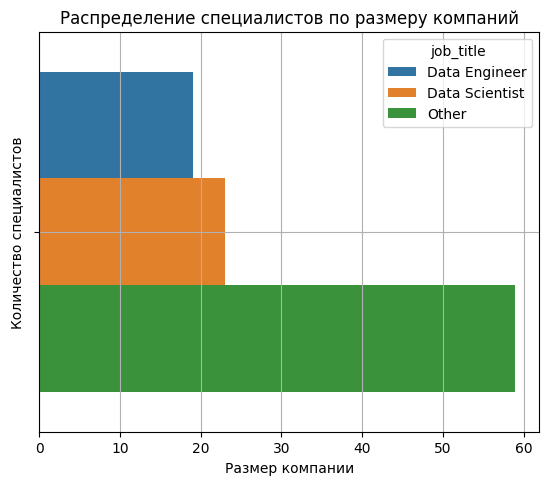

In [47]:
# main_df[main_df.job_title != 'Other'].groupby(['job_title', 'company_size']).agg('describe')
# t1 = main_df[main_df.job_title != 'Other'].pivot_table(

t1 = main_df.pivot_table(
    values='salary_in_usd',
    # index='job_title',
    index='company_size',
    # columns='company_size',
    columns='job_title',
    aggfunc='count'
)
# t3 = main_df.groupby('company_size')['company_size'].count()
t1['total'] = t1['Data Engineer'] + t1['Data Scientist'] + t1['Other']
t1['ds_percent'] = round(t1['Data Scientist'] / t1['total'] * 100)
t1['de_percent'] = round(t1['Data Engineer'] / t1['total'] * 100)
display(t1)
# display(t1.index)
# display(t1.columns)
# display(t1.Other.iloc[0])
# t2 = main_df[main_df.job_title != 'Other'].groupby(['job_title', 'company_size'])[['job_title']].count().unstack()
t2 = main_df.pivot_table(
    values='salary_in_usd',
    index='job_title',
    columns='company_size',
    aggfunc='count'
)
display(t2)
display(t2.L.sum())
t2.L = round(t2.L / t2.L.sum() * 100)
t2.M = round(t2.M / t2.M.sum() * 100)
t2.S = round(t2.S / t2.S.sum() * 100)
display(t2)
# display(t3)
# print(type(t3))
# display(list(t3.index))
# display(list(t3.values))

jobs_spreads = plt.figure(figsize=(5, 4))
axes = jobs_spreads.add_axes([0, 0, 1, 1])
sns.barplot(
    data=t2,
    x='L',
    # y='ds_percent',
    hue='job_title',
    # orient='v',
    # order=['S', 'M', 'L'],
    ax=axes
)
axes.set_title('Распределение специалистов по размеру компаний')
axes.set_xlabel('Размер компании')
axes.set_ylabel('Количество специалистов')
axes.grid()

work_year  experience_level  employment_type  \
company_size job_title                                                      
L            Data Engineer          37                37               37   
             Data Scientist         45                45               45   
M            Data Engineer          89                89               89   
             Data Scientist         77                77               77   
S            Data Engineer           6                 6                6   
             Data Scientist         21                21               21   

                             salary_in_usd  employee_residence  remote_ratio  \
company_size job_title                                                         
L            Data Engineer              37                  37            37   
             Data Scientist             45                  45            45   
M            Data Engineer              89                  89            89   
             Data Scientist             77                  77            77   
S            Data Engineer               6                   6             6   
             Data Scientist             21                  21            21   

                             company_location  
company_size job_title                         
L            Data Engineer                 37  
             Data Scientist                45  
M            Data Engineer                 89  
             Data Scientist                77  
S            Data Engineer                  6  
             Data Scientist                21

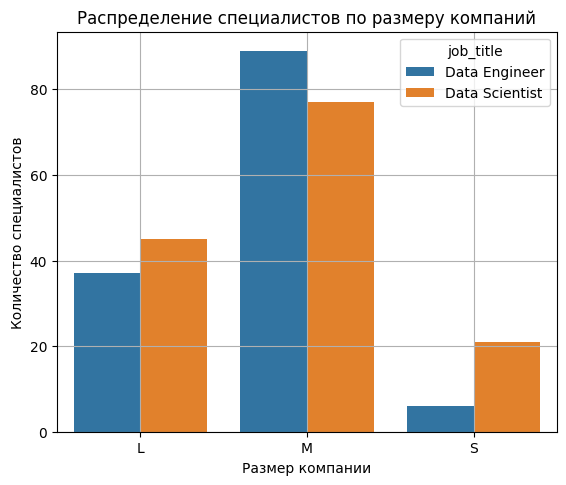

In [117]:
salary_median_df = main_df[main_df.job_title != 'Other']\
                          .loc[main_df.work_year == '2022']\
                          .groupby(['job_title', 'work_year'])\
                          [['salary_in_usd']].median()
# display(salary_median_df)

# main_df[main_df.job_title != 'Other'].groupby(['job_title', 'company_size'])[['job_title']].count()
job_counts_df = main_df[main_df.job_title != 'Other'].groupby(['company_size', 'job_title']).agg('count')
display(job_counts_df)

ds_salary_mean_df = main_df[main_df.job_title == 'Data Scientist']\
                           .groupby(['company_size'])[['salary_in_usd']]\
                           .mean()

jobs_spread = plt.figure(figsize=(5, 4))
axes = jobs_spread.add_axes([0, 0, 1, 1])
sns.barplot(
    data=job_counts_df,
    x='company_size',
    y='work_year',
    hue='job_title',
    # orient='v',
    # order=['S', 'M', 'L'],
    ax=axes
)
axes.set_title('Распределение специалистов по размеру компаний')
axes.set_xlabel('Размер компании')
axes.set_ylabel('Количество специалистов')
axes.grid()

## 4. Дополнительное исследование ##

### 4.1. Если расширить роли **`Data Scientist`** и **`Data Engineer`**? ###

In [60]:
copy_df.job_title.unique()

array(['Data Scientist', 'Machine Learning Scientist',
       'Big Data Engineer', 'Product Data Analyst',
       'Machine Learning Engineer', 'Data Analyst', 'Lead Data Scientist',
       'Business Data Analyst', 'Lead Data Engineer', 'Lead Data Analyst',
       'Data Engineer', 'Data Science Consultant', 'BI Data Analyst',
       'Director of Data Science', 'Research Scientist',
       'Machine Learning Manager', 'Data Engineering Manager',
       'Machine Learning Infrastructure Engineer', 'ML Engineer',
       'AI Scientist', 'Computer Vision Engineer',
       'Principal Data Scientist', 'Data Science Manager', 'Head of Data',
       '3D Computer Vision Researcher', 'Data Analytics Engineer',
       'Applied Data Scientist', 'Marketing Data Analyst',
       'Cloud Data Engineer', 'Financial Data Analyst',
       'Computer Vision Software Engineer',
       'Director of Data Engineering', 'Data Science Engineer',
       'Principal Data Engineer', 'Machine Learning Developer',
       

В списке есть ещё несколько должностей, которые можно добавить в категории
**`Data Scientist`** и **`Data Engineer`**. Можно составить соответствующие
списки должностей для увеличения данных по этим категориям.

In [ ]:
ds_list = ['Data Scientist',
           'Lead Data Scientist',
           'Data Science Consultant',
           'Director of Data Science',
           'Research Scientist',
           'Principal Data Scientist',
           'Data Science Manager',
           'Applied Data Scientist',
           'Applied Machine Learning Scientist',
           'Head of Data Science',
           'Staff Data Scientist'
          ]
de_list = ['Data Engineer',
           'Big Data Engineer',
           'Lead Data Engineer'
           'Data Engineering Manager',
           'Data Analytics Engineer',
           'Cloud Data Engineer',
           'Director of Data Engineering',
           'Data Science Engineer',
           'Principal Data Engineer',
           'Analytics Engineer'
          ]

### 4.2. Если нормализовать данные в признаке **`salary_in_usd`**? ###